# Preprocessing Study

## 1. Setup

In [2]:
import os, sys
import shutil
import math
from tqdm.notebook import tqdm
import time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from scipy.ndimage import zoom

In [3]:
# PATH Setting
DIR_PATH = 'F:/20210730_samples'
DATA_PATH = os.path.join(DIR_PATH, 'rawdata')
SAVE_PATH = os.path.join(DIR_PATH, 'numpy')
print (os.path.exists(DIR_PATH))

True


## 2. Numpy Conversion

In [126]:
def path2dcm(PATH):
    DCM_REF = ['IMG-0001-00001.dcm', 'IMG-0002-00001.dcm', 'IMG-0003-00001.dcm']
    IDX_REF = [None, None]
    CT_FILES, PT_FILES = [], []

    for REF in DCM_REF:
        REF_PATH = os.path.join(PATH, REF)
        dicom_ref = pydicom.dcmread(REF_PATH)
        if dicom_ref.SeriesDescription == 'PRE_CT_TORSO':
            IDX_REF[0] = REF[:8]
        elif dicom_ref.SeriesDescription == 'PET ax':
            IDX_REF[1] = REF[:8]
    
    if IDX_REF[0] is None: print('CT DATA EMPTY')
    if IDX_REF[1] is None: print('PT DATA EMPTY')

    for DCM in os.listdir(PATH):
        DCM_PATH = os.path.join(PATH, DCM)
        if DCM[:8] == IDX_REF[0]: #CT
            CT_FILES.append(pydicom.dcmread(DCM_PATH))
        elif DCM[:8] == IDX_REF[1]: #PT
            PT_FILES.append(pydicom.dcmread(DCM_PATH))
    return CT_FILES, PT_FILES[::-1]

In [127]:
def dcm2voxel(FILES):
    dsRef = FILES[0]
    dims = (int(dsRef.Rows), int(dsRef.Columns), len(FILES))
    voxel = np.zeros(dims)
    for i, DCM in enumerate(FILES):
        voxel[:,:,i] = DCM.pixel_array
    return voxel

In [129]:
for i in tqdm(range(len(os.listdir(DATA_PATH))), desc='Numpy Processing'):
    PATIENT_PATH = os.listdir(DATA_PATH)[i]
    if len(PATIENT_PATH) <= 3:
        patient_num = int(PATIENT_PATH[:int(PATIENT_PATH.find('a'))])
        PATIENT_PATH = os.path.join(DATA_PATH, PATIENT_PATH)
        PATIENT_PATH = os.path.join(PATIENT_PATH, os.listdir(PATIENT_PATH)[0])
        ct_files, pet_files = path2dcm(PATIENT_PATH)
        ct_voxel, pet_voxel = dcm2voxel(ct_files), dcm2voxel(pet_files)
        np.save(os.path.join(SAVE_PATH + '/CT_vanilla', 'CT_{:02d}'.format(patient_num)), ct_voxel)
        np.save(os.path.join(SAVE_PATH + '/PET_vanilla', 'PET_{:02d}'.format(patient_num)), pet_voxel)

Numpy Processing:   0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jinyo\miniconda3\envs\voxelmorph\lib\site-packages\pydicom\filereader.py:300: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


In [21]:
def mid_plot(PATH, grid, view=0, cmap=plt.cm.gray, vmax=None):

    fig = plt.figure(figsize=(15,15))
    axes = []
 
    for i, NPY_PATH in enumerate(os.listdir(PATH)):
        voxel = np.load(os.path.join(PATH, NPY_PATH))
        mid_len = voxel.shape[view]
        axes.append(fig.add_subplot(grid[0], grid[1], i+1))
        axes[-1].set_title(NPY_PATH, fontsize=20)
        if view == 0:
            plt.imshow(voxel[int(mid_len/2),:,:].T, aspect='auto', cmap=cmap, vmax=vmax)
        elif view == 1:
            plt.imshow(voxel[:,int(mid_len/2),:].T, aspect='auto', cmap=cmap, vmax=vmax)
        else:
            plt.imshow(voxel[:,:,int(mid_len/2)], aspect='auto', cmap=cmap, vmax=vmax)    

    plt.show()

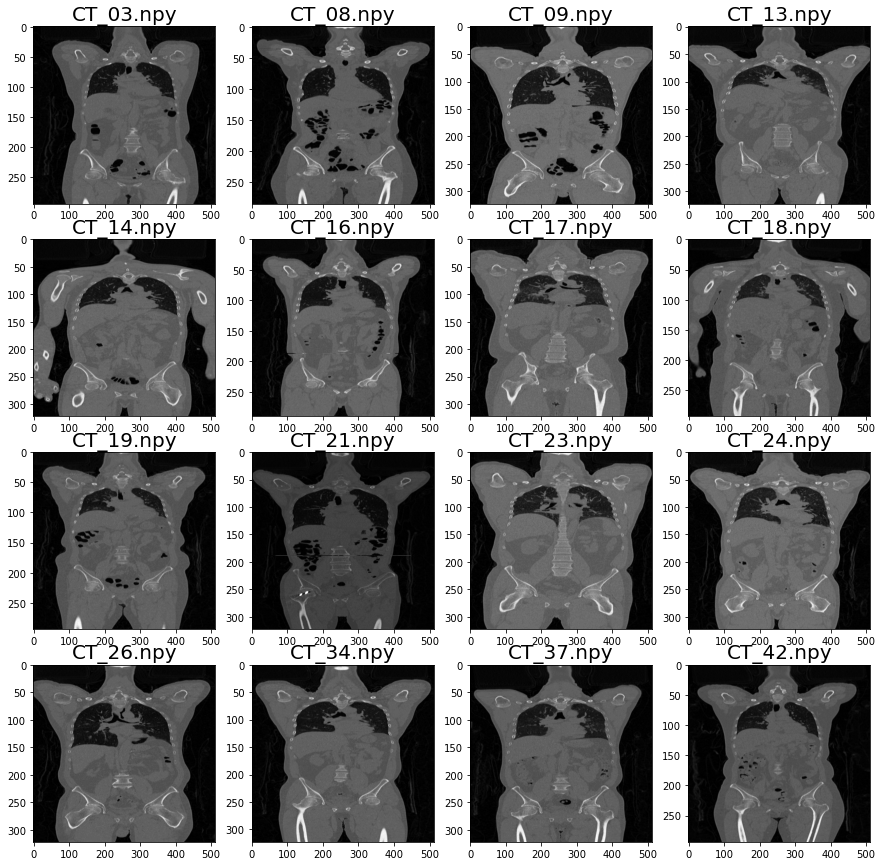

In [141]:
mid_plot(SAVE_PATH + '/CT_vanilla', grid=(4,4))

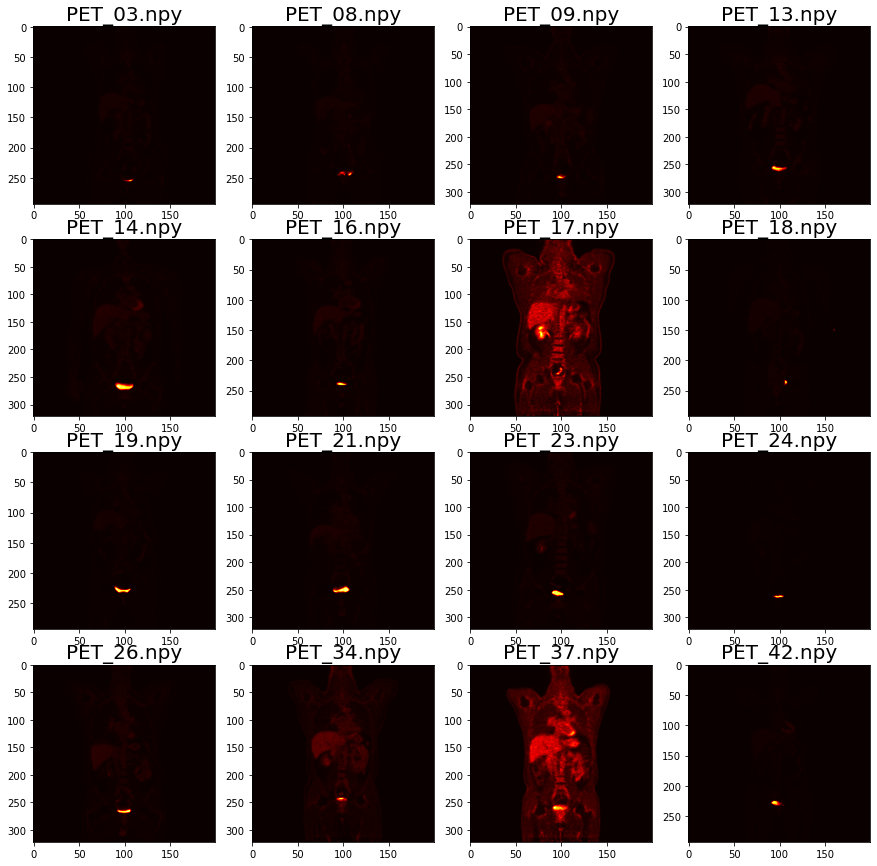

In [142]:
mid_plot(SAVE_PATH + '/PET_vanilla', grid=(4,4), cmap=plt.cm.hot)

## 3. Voxel Analysis

In [134]:
PET_PATH = SAVE_PATH + '/PET_vanilla'
SAMPLE_PATH = os.path.join(PET_PATH, os.listdir(PET_PATH)[0])
voxel_sample = np.load(SAMPLE_PATH)
print (voxel_sample.shape)

(200, 200, 293)


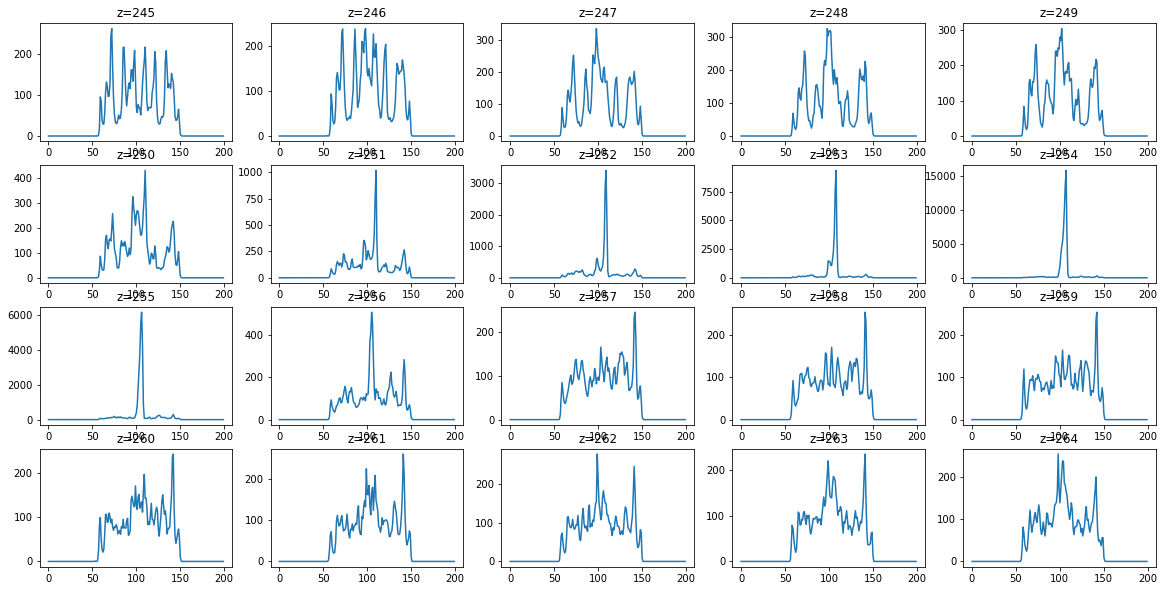

In [135]:
fig = plt.figure(figsize=(20,10))
axes = []

for i in range(20):
    axes.append(fig.add_subplot(4, 5, i+1))
    axes[-1].plot(voxel_sample[100,:,245+i])
    axes[-1].set_title('z={:03d}'.format(245+i))

plt.show()

In [138]:
PET_PATH = SAVE_PATH + '/PET_vanilla'
SAMPLE_PATH = os.path.join(PET_PATH, os.listdir(PET_PATH)[14])
voxel_sample = np.load(SAMPLE_PATH)
print (voxel_sample.shape)

(200, 200, 322)


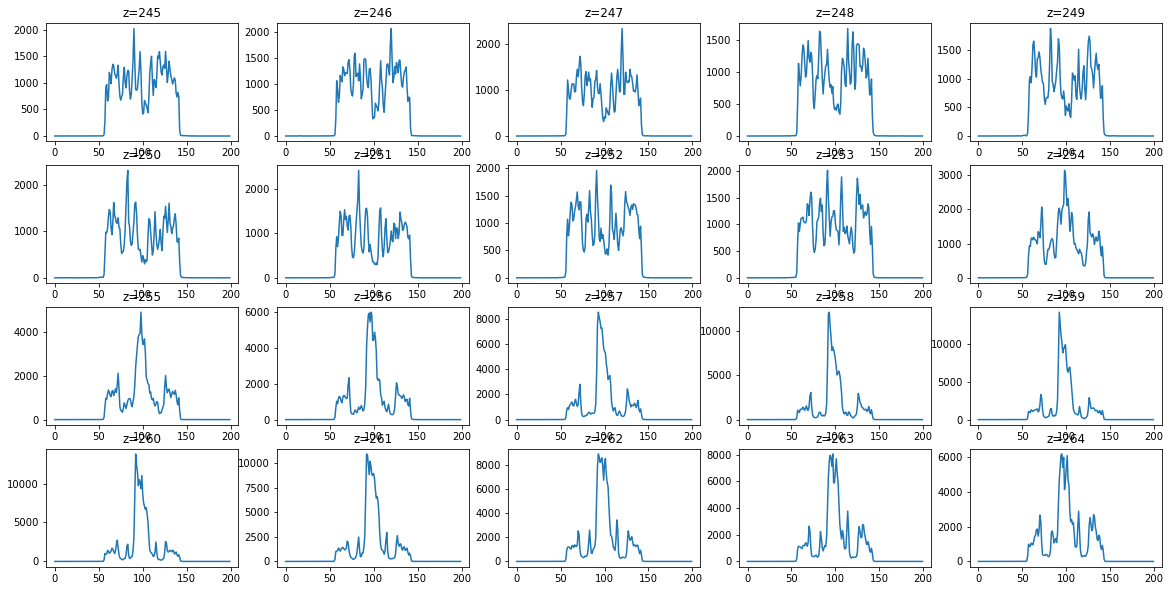

In [139]:
fig = plt.figure(figsize=(20,10))
axes = []

for i in range(20):
    axes.append(fig.add_subplot(4, 5, i+1))
    axes[-1].plot(voxel_sample[100,:,245+i])
    axes[-1].set_title('z={:03d}'.format(245+i))

plt.show()

### Possible Ideas
- Normalization By Segmented Signals
- Metabolic Constraint

## 4. Resizing / Normalization

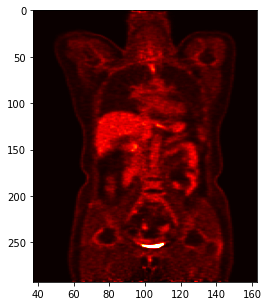

In [5]:
# Spacing Check
PET_example = 'F:/20210730_samples/numpy/PET_vanilla/PET_03.npy'
voxel_sample = np.load(PET_example)
voxel_len = voxel_sample.shape[0]
TotalSpacing = 125
plt.figure(figsize=(4,5))
plt.xlim(voxel_len/2-TotalSpacing/2, voxel_len/2+TotalSpacing/2)
plt.imshow(voxel_sample[int(voxel_len/2),:,:].T, aspect='auto', cmap=plt.cm.hot, vmax=1000)
plt.show()

In [6]:
def path2spacing(PATH):
    DCM_REF = ['IMG-0001-00001.dcm', 'IMG-0002-00001.dcm', 'IMG-0003-00001.dcm']
    CT_spacing, PT_spacing = 0, 0

    for REF in DCM_REF:
        REF_PATH = os.path.join(PATH, REF)
        dicom_ref = pydicom.dcmread(REF_PATH)
        if dicom_ref.SeriesDescription == 'PRE_CT_TORSO':
            CT_spacing = dicom_ref.PixelSpacing
        elif dicom_ref.SeriesDescription == 'PET ax':
            PT_spacing = dicom_ref.PixelSpacing
    
    if CT_spacing == 0: print('CT DATA EMPTY')
    if PT_spacing == 0: print('PT DATA EMPTY')

    return CT_spacing, PT_spacing

In [7]:
for i in tqdm(range(len(os.listdir(DATA_PATH))), desc='PixelSpacing Check'):
    PATIENT_PATH = os.listdir(DATA_PATH)[i]
    if len(PATIENT_PATH) <= 3:
        patient_num = int(PATIENT_PATH[:int(PATIENT_PATH.find('a'))])
        PATIENT_PATH = os.path.join(DATA_PATH, PATIENT_PATH)
        PATIENT_PATH = os.path.join(PATIENT_PATH, os.listdir(PATIENT_PATH)[0])
        print(path2spacing(PATIENT_PATH))

PixelSpacing Check:   0%|          | 0/32 [00:00<?, ?it/s]

([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])
([0.9765625, 0.9765625], [4.07283, 4.07283])


In [8]:
# Pixel Length Calculation
# [CT] 512 * 0.9765625 = [PET] Pixel * 4.07283
print ('PET Pixel Number =', 512 * (0.9765625/4.07283))

PET Pixel Number = 122.76476062099327


In [17]:
CT_PATH = SAVE_PATH + '/CT_vanilla'
NEW_CT_PATH = SAVE_PATH + '/CT_target'
PET_PATH = SAVE_PATH + '/PET_vanilla'
NEW_PET_PATH = SAVE_PATH + '/PET_resize'
TotalSpacing = 123
ShapeList = [128, 128, 256]
RangeDict = {'CT':[0, 4095], 'PT':[0, 32767]}

for i in tqdm(range(len(os.listdir(CT_PATH))), desc='CT Standardization'):
    # Load
    NPY_PATH = os.listdir(CT_PATH)[i]
    voxel = np.load(os.path.join(CT_PATH, NPY_PATH))
    # Resizing
    resize_shape = [ShapeList[j]/voxel.shape[j] for j in range(3)]
    voxel = zoom(voxel, resize_shape)
    if voxel.shape != tuple(ShapeList):
        print ('[{}] Error Shape:'.format(NPY_PATH), voxel.shape)
    # Normalization
    voxel = voxel / RangeDict['CT'][1]
    # Save
    np.save(os.path.join(NEW_CT_PATH, 'CT_{}'.format(NPY_PATH[3:5])), voxel)

for i in tqdm(range(len(os.listdir(PET_PATH))), desc='PET Standardization'):
    # Load
    NPY_PATH = os.listdir(PET_PATH)[i]
    voxel = np.load(os.path.join(PET_PATH, NPY_PATH))
    # Pixel Correction
    Pad_X = int((voxel.shape[0] - TotalSpacing)/2)
    Pad_Y = int((voxel.shape[1] - TotalSpacing)/2)
    voxel = voxel[Pad_X:Pad_X+TotalSpacing, Pad_Y:Pad_Y+TotalSpacing, :]
    # Resizing
    resize_shape = [ShapeList[j]/voxel.shape[j] for j in range(3)]
    voxel = zoom(voxel, resize_shape)
    if voxel.shape != tuple(ShapeList):
        print ('[{}] Error Shape:'.format(NPY_PATH), voxel.shape)
    # Normalization
    voxel = voxel / RangeDict['PT'][1]
    # Save
    np.save(os.path.join(NEW_PET_PATH, 'PET_{}'.format(NPY_PATH[4:6])), voxel)

CT Standardization:   0%|          | 0/16 [00:00<?, ?it/s]

PET Standardization:   0%|          | 0/16 [00:00<?, ?it/s]

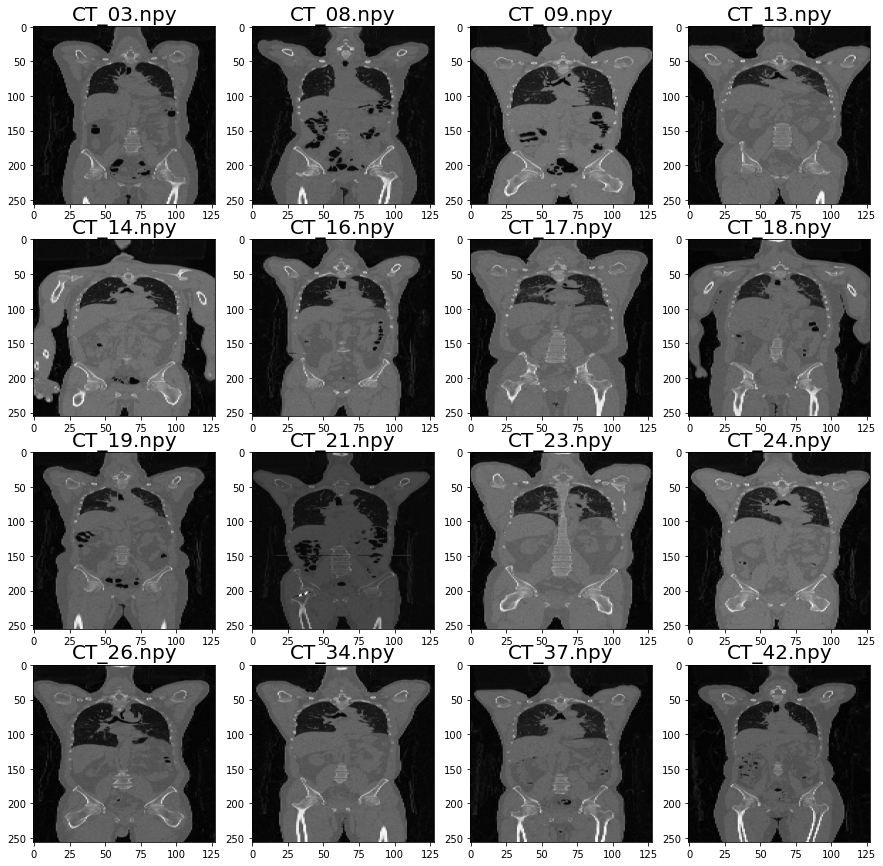

In [18]:
mid_plot(NEW_CT_PATH, grid=(4,4))

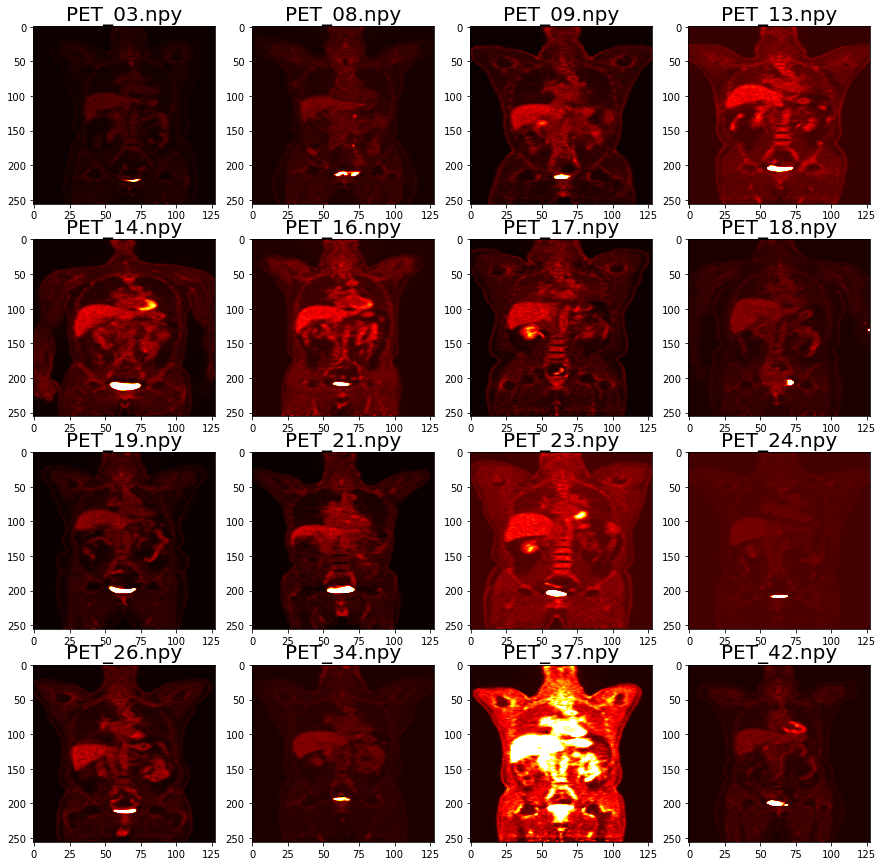

In [24]:
mid_plot(NEW_PET_PATH, grid=(4,4), cmap=plt.cm.hot, vmax=0.1)